In [1]:
import logging
import sys
from pathlib import Path


logging.basicConfig(
    level=logging.INFO,
    format="%(levelname)s: %(message)s",
)

# Add the src directory to the Python path
sys.path.append(str(Path.cwd().parent.parent))

In [2]:
from src.nas.mlp_chromosome import RawChromosome


low, high = RawChromosome.get_bounds()
low, high

(array([0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
 array([7, 8, 3, 7, 7, 7, 2, 3, 1, 1, 6, 3]))

In [3]:
from src.nas.mlp_nas_problem import MlpNasProblem
from src.nas.nas import MlpNasParams
from src.datasets.vertebral_dataset import VertebralDataset
from src.datasets.breast_cancer_dataset import BreastCancerDataset


DatasetClass = BreastCancerDataset
params = MlpNasParams(
    epochs=10,
    patience=5,
    amount_of_evaluations=5,
    population_size=50,
    population_offspring_count=20,
    algorithm_generations=5,
    population_store_file=DatasetClass.__name__ + "_population.csv",
)
problem = MlpNasProblem(params, DatasetClass)

problem.get_min_complexity(), problem.get_max_complexity()

INFO: Loading cached vertebral from /home/nur/Projects/vut-ip1-nn-quantization/datasets_cache/vertebral_cache.pkl
INFO: Loading cached breast_cancer from /home/nur/Projects/vut-ip1-nn-quantization/datasets_cache/breast_cancer_cache.pkl


(234.0, np.float64(3196.7999999999997))

In [4]:
plow = problem.get_nn_params(RawChromosome(low).parse())
phigh = problem.get_nn_params(RawChromosome(high).parse())

problem.compute_nn_complexity(plow), problem.compute_nn_complexity(phigh)

(234.0, np.float64(3196.7999999999997))

In [5]:
from pymoo.optimize import minimize

from src.constants import SEED


algorithm = params.get_algorithm()
termination = params.get_termination()

res = minimize(problem, algorithm, verbose=True, seed=SEED, termination=termination)

params.store_population(res, params.population_store_file)

print(f"Solutions: {res.X}")
print(f"Objectives: {res.F}")

INFO: Population file loaded successfully


n_gen  |  n_eval  | n_nds  |      eps      |   indicator  
     1 |        1 |      1 |             - |             -


KeyboardInterrupt: 

In [ ]:
from dataclasses import asdict

from pprint import pprint
import pandas as pd
from pymoo.core.result import Result


def res_to_df(res: Result) -> pd.DataFrame:
    data = []
    for i in range(len(res.X)):
        x = res.X[i]
        f = res.F[i]
        accuracy = problem.denormalize(-f[0], 0, 100)
        complexity = problem.denormalize(
            f[1], problem.get_min_complexity(), problem.get_max_complexity()
        )

        ch = RawChromosome(x).parse()
        params = problem.get_nn_params(ch)

        data.append(
            {
                "Accuracy": accuracy,
                "Complexity": complexity,
                **asdict(params),
                "Chromosome": x,
            }
        )

    return pd.DataFrame(data)


df = res_to_df(res)
df

,Accuracy,Complexity,in_height,hidden_height,out_height,hidden_layers,hidden_layers_bitwidths,in_bitwidth,activation,dropout_rate,learning_rate,weight_decay,epochs,quantization_mode,Chromosome
0,80.357143,234.0,13,7,2,0,"[5, 2, 5]",2,ActivationModule.BINARIZE,0.0,0.005,0.005,10,QMode.DET,"[1, 7, 0, 4, 1, 4, 0, 2, 0, 1, 5, 1]"


In [ ]:
ch = RawChromosome(df.loc[0]["Chromosome"]).parse()
params = problem.get_nn_params(ch)
pprint(params)

MLPParams(in_height=13,
          hidden_height=np.int64(7),
          out_height=2,
          hidden_layers=np.int64(0),
          hidden_layers_bitwidths=[5, 2, 5],
          in_bitwidth=2,
          activation=<ActivationModule.BINARIZE: 'binary'>,
          dropout_rate=0.0,
          learning_rate=0.005,
          weight_decay=0.005,
          epochs=10,
          quantization_mode=<QMode.DET: 'det'>)


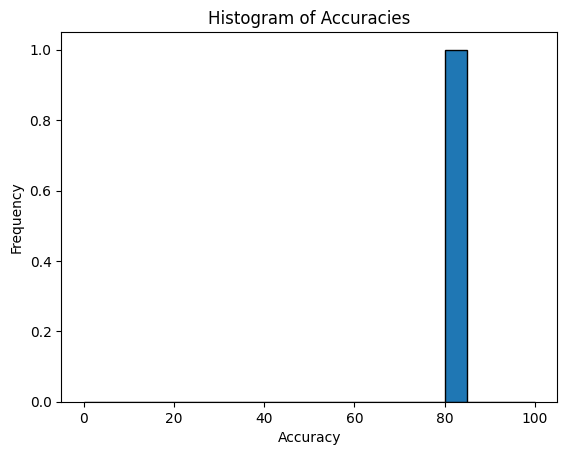

In [ ]:
from matplotlib import pyplot as plt

from src.models.mlp import MLPEvaluator


def hist_accuracies(accuracies: list[float]) -> plt.Figure:
    fig, ax = plt.subplots()
    ax.hist(accuracies, bins=20, range=(0, 100), edgecolor="black")
    ax.set_title("Histogram of Accuracies")
    ax.set_xlabel("Accuracy")
    ax.set_ylabel("Frequency")
    return fig


fig = hist_accuracies(df["Accuracy"])

/home/nur/Projects/vut-ip1-nn-quantization/src/nas/plot.py:43: UserWarning: Attempting to set identical low and high xlims makes transformation singular; automatically expanding.
  plt.xlim(


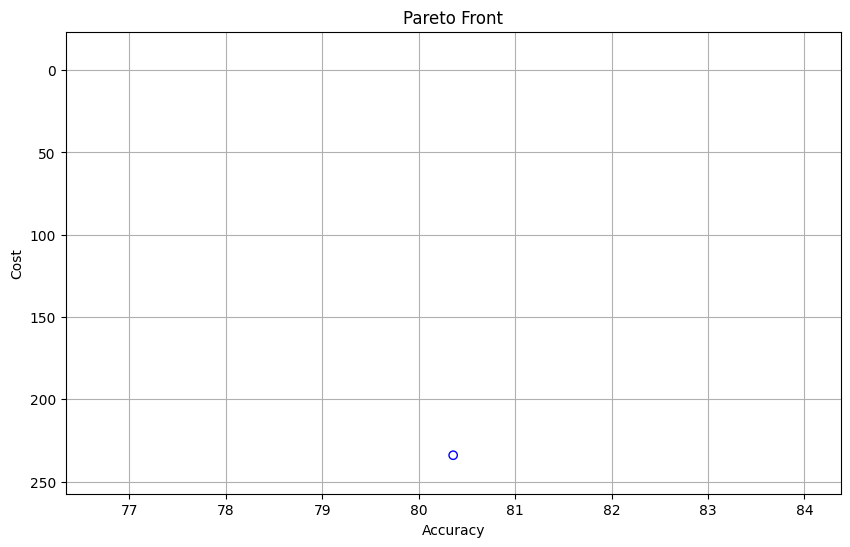

In [ ]:
from src.nas import plot

plot.plot_pareto_front(df["Accuracy"], df["Complexity"])